Purpose: The purpose of this notebook is to practice ML logistic regression models using the titanic kaggle challenge found here: https://www.kaggle.com/c/titanic/code 

In [ ]:
Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
pwd


'/Users/danielaquijano/Documents/GitHub/Python-ML'

In [11]:
#Import data from source_files folder
train = pd.read_csv('/Users/danielaquijano/Documents/GitHub/Python-ML/source_files/titanic_train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [39]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Check for missing data

In [10]:
train.isna().sum() #We get a column by column summary of the number of missing values

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

<AxesSubplot:>

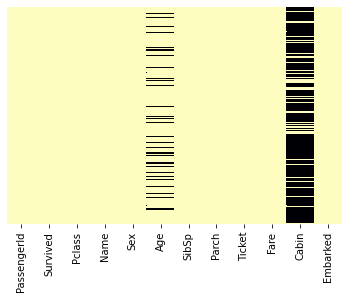

In [23]:
#Make Heat map depicting missing values by column
#Shows a lot of cabin data missing
sns.heatmap(train.isna(),yticklabels=False,cbar=False,cmap='magma_r')

<AxesSubplot:xlabel='Survived', ylabel='count'>

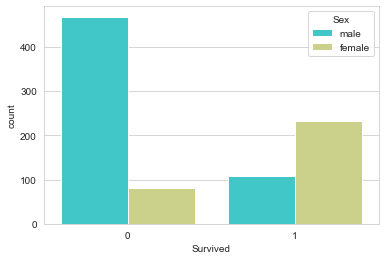

In [35]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train,palette='rainbow', hue='Sex') #More women survived compared to men

<AxesSubplot:xlabel='Survived', ylabel='count'>

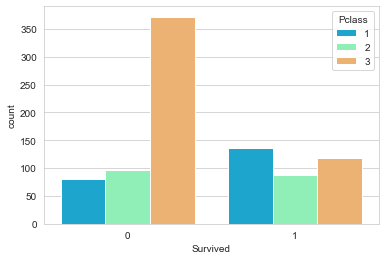

In [36]:
#Compare survivor rate based on class on the ship
#People in 3rd class (cheapest class) had the lowest survial rate
sns.countplot(x='Survived',data=train,palette='rainbow', hue='Pclass')

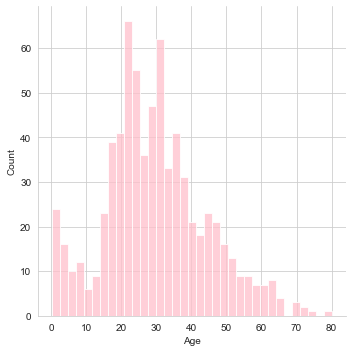

In [38]:
#Now investigate the age ditribution on the ship
#Average age between 20 and 40
sns.displot(train['Age'].dropna(),kde=False,color='pink',bins=35)

<AxesSubplot:xlabel='SibSp', ylabel='count'>

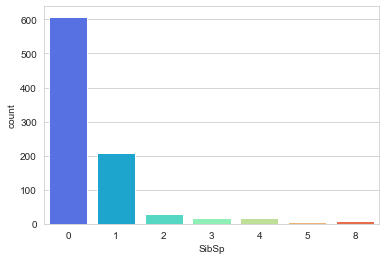

In [41]:
#Check related passengers on board (Column SibSp=siblings/spouses)
sns.countplot(x='SibSp',data=train, palette='rainbow')

In [50]:
pip install cufflinks

     |████████████████████████████████| 81 kB 958 kB/s eta 0:00:01
     |████████████████████████████████| 27.7 MB 5.5 MB/s eta 0:00:01     |███████████████████             | 16.5 MB 1.4 MB/s eta 0:00:08


  Created wheel for cufflinks: filename=cufflinks-0.17.3-py3-none-any.whl size=67922 sha256=c2129cc9b27f0df177304f24a06178acb66d65c6d3ba69ab5e3a2ac9ce7c76c9
  Stored in directory: /Users/danielaquijano/Library/Caches/pip/wheels/6b/76/62/6da97734911ffcbdd559fd1a3f28526321f0ae699182a23866
Successfully built cufflinks
Note: you may need to restart the kernel to use updated packages.


In [53]:
#Check the fares paid to enter the ship
#Most tickets hover between 0 and 100
#Interactive plot with cufflinks
import cufflinks as cf
cf.go_offline()
train['Fare'].iplot(kind='hist',bins=40,color='purple')

Now, tackle missing data

<AxesSubplot:xlabel='Pclass', ylabel='Age'>

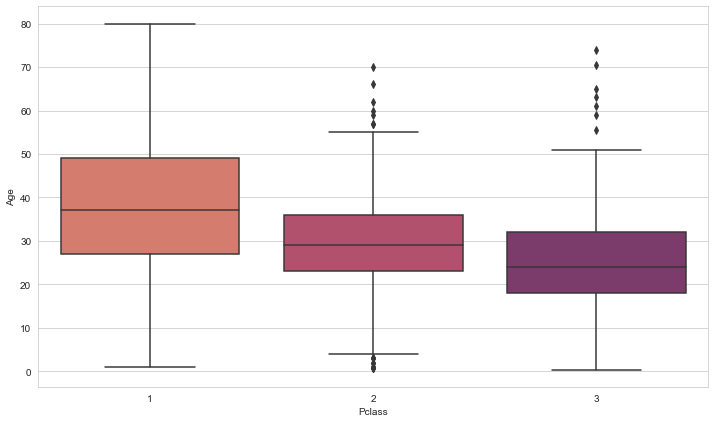

In [55]:
#Use imoputation to fill in age missing values using the average age for each class
#First visualize age by class
#Higher class passengers tend to be older
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='flare')
train['Fare'].iplot(kind='hist',bins=40,color='purple')

In [61]:
box_age = train[['Pclass', 'Age']]
box_age.pivot(columns='Pclass', values='Age').iplot(kind='box')
#Here we can visualize the median valeus for each class

In [ ]:
def age_replace(columns): #Pass the column for age first, then pass in the column for class
    Age = columns[0]
    Pclass = columns[1]
    
    if pd.isnull(Age): #Check if age is missing, then

        if Pclass == 1: 
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age